# Naive Bayes
The first part of the project revolves around the implementation of a custom Naive Bayes algorithm. Initially, the train and test data from the IMDb dataset is retrieved. Following necessary preprocessing steps, the train reviews are used to train the Naive Bayes algorithm. Subsequently, the performance of the algorithm is evaluated using the test reviews.

## Imports
Includes all the imports necessary to run the project. Ensure it runs as intended before continuing with the rest of the jupyter cells.

In [1]:
import tensorflow as tf
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from IPython.display import display, Markdown
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.naive_bayes import BernoulliNB

from tensorflow.keras.utils import plot_model
from IPython.display import Image

## Hyperparameter Configuration
Following the assignment guidelines, three hyperparameters will be used; m (for the size of the vocabulary), n (for the n-most common words in the training data), and k (for the k-least common words in the training data), the last 2 of which will not be included in the vocabulary.


In [2]:
m = 2700
n = 150
k = 50

## Data Fetch
Fetching the documents (reviews in this case), while taking into account the aforementioned m, n and k hyperparameters.

In [3]:
# fetching the reviews
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)

# make a dictionary out of the words provided
word_index = tf.keras.datasets.imdb.get_word_index()
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'

# x_train_text and x_test_text will consist of strings that represent reviews, but limited to the dictionary provided
x_train_text = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test_text = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

## Data Vectorization
A binary vectorizer will be used to convert text data into two binary matrices, one for the train data, and one for the test data. Each row will represent a review, and each column will represent a unique word in the vocabulary. 

In [4]:
binary_vectorizer = CountVectorizer(binary=True)

# transforming the train and test text reviews into binary matrices
x_train_binary = binary_vectorizer.fit_transform(x_train_text)
x_test_binary = binary_vectorizer.transform(x_test_text)

# extracting the vocabulary from the vectorizer
train_vocab = binary_vectorizer.get_feature_names_out()

x_train = np.array(x_train_binary.toarray())
x_test = np.array(x_test_binary.toarray())

## Bernoulli Naive Bayes
The multivariate Bernoulli variant of Naive Bayes will be used for the Naive Bayes implementation. Log probabilities will be utilized for improved performance.

In [6]:
class CustomBernoulliNaiveBayes:
    def __init__(self):
        self.log_apriori_positive = None
        self.log_apriori_negative = None
        self.log_prob_feature_exists_pos = None
        self.log_prob_feature_exists_neg = None
    
    def fit(self, x, y, alpha=1):
        """
        Fit the Bernoulli Naive Bayes model on the training data.

        Arguments:
            x: The training data (2D array of shape (dataset size, number of features))
            y: The corresponding actual classification for each review (1D array of shape (number of data))
            alpha (optional, default = 1): The parameter used for Laplace smoothing.

        Returns:
            self: The fitted CustomBernoulliNaiveBayes instance (to allow for method chaining).
        """
        """
        log_apriori_positive: log(P(C=1)). Set to the logarithm of (total number of positive reviews / the total number of reviews) from our training data
        log_apriori_negative: log(P(C=0)). Set to the logarithm of (total number of negative reviews / the total number of reviews) from our training data
        """        
        self.log_apriori_positive = np.log(len(np.where(y == 1)[0]) / len(y))
        self.log_apriori_negative = np.log(len(np.where(y == 0)[0]) / len(y))

        """
        log_prob_feature_exists_pos/log_prob_feature_exists_neg are two arrays, of size equal to the total amount
        of features (words in the vocabulary). Each index represents the logarithm of the (smoothed) probability the category
        will be positive or negative respectively, given that the feature in that specific index is present in the training data.
        In other words, for the m features present, the item on the i-th index of log_prob_feature_exists_pos represents
        the logarithm of the probability of p(Xi = xi | C = 1) for the i-th feature, and likewise log_prob_feature_exists_neg
        represents p(Xi = xi | C = 0) for the negative category. 
        """
        self.log_prob_feature_exists_pos = np.log((np.sum(x[y == 1], axis=0) + alpha) / (len(np.where(y == 1)[0]) + 2 * alpha))
        self.log_prob_feature_exists_neg = np.log((np.sum(x[y == 0], axis=0) + alpha) / (len(np.where(y == 0)[0]) + 2 * alpha))

        return self
    
    def predict(self, x):
        """
        Predict the classifications for the given test data.

        Arguments:
            x: The test data (2D array of shape (dataset size, number of features))

        Returns:
            The predictions according to the model (1D array of shape (dataset size))
        """
        
        num_test_data = x.shape[0]

        # making 2 num_test_data sized arrays, consisting of the log apriori positive/negative probabilities
        log_positive_probs = np.full(num_test_data, self.log_apriori_positive)
        log_negative_probs = np.full(num_test_data, self.log_apriori_negative)

        """
        For each test sample, we calculate the prediction as follows:
        For each feature in our vocabulary, if it is present in the sample, we add the logarithm of the probability 
        of the feature given the positive category (p(Xi = xi | C = 1)) to the log apriori probability of the positive category. 
        If the feature is absent, we add the logarithm of the complement probability (1 - p(Xi = xi | C = 1)) to the log apriori probability.
        This is done for both positive and negative categories.
        
        Probabilities are filtered through multiplication: x for feature presence, 1-x
        for absence (since x==1 means the feature is present, and x==0 means the feature is absent).
        """
        log_positive_probs += np.sum(x * self.log_prob_feature_exists_pos + (1 - x) * np.log(1 - np.exp(self.log_prob_feature_exists_pos)), axis=1)
        log_negative_probs += np.sum(x * self.log_prob_feature_exists_neg + (1 - x) * np.log(1 - np.exp(self.log_prob_feature_exists_neg)), axis=1)

        # for each test sample, choose the class with the higher probability for the final prediction
        predictions = np.where(log_positive_probs > log_negative_probs, 1, 0)

        return predictions

## Model Evaluation and Visualisation Functions
Additional functions that were used to evaluate the model's performance and to visualise the results.

In [8]:
def evaluate_metrics(estimator, x_train, y_train, x_test, y_test, splits=5):
    """
    Calculates accuracy, precision, recall, and f1-score for the given splits.

    Arguments:
        estimator: The estimator that will be evaluated.
        x_train: The numpy array of binary train data.
        y_train: The corresponding actual positive or negative classifications for x_train.
        x_test: The numpy array of binary test data.
        y_test: The corresponding actual positive or negative classifications for x_test.
        splits (optional, default = 5): The number of splits by which to divide the data.

    Returns:
        A dictionary containing evaluation metrics for both train and test datasets.
    """

    # sanity check: making sure x_train and x_test match the shapes of y_train and y_test respectively
    if x_train.shape[0] != y_train.shape[0]:
        raise ValueError("The number of data points in x_train and y_train must be the same. "
                         f"Found {x_train.shape[0]} data points in x, but {y_train.shape[0]} data points in y.")
    elif x_test.shape[0] != y_test.shape[0]:
        raise ValueError("The number of data points in x_test and y_test must be the same. "
                         f"Found {x_test.shape[0]} data points in x, but {y_test.shape[0]} data points in y.")

    # x_splits/y_splits: Numpy arrays of size equal to splits; each index contains the data of the corresponding split
    x_splits = np.array_split(x_train, splits, axis=0)
    y_splits = np.array_split(y_train, splits, axis=0)
    
    # test_predictions: Initialised to None, will contain the predictions for the test data.
    test_predictions = None
    
    # curr_x_split/curr_y_split: Initialised to None, will be updated throughout the loop following.
    curr_x_split = None
    curr_y_split = None

    # split_sizes: Since we opted for np.array_split instead of np.split, keeping track of the exact size of each split.
    split_sizes = np.array([])
    
    # train/test metric scores: Initialising empty arrays, which will keep track of the metrics we are tracking as the training data increases.
    train_accuracy_scores = np.array([])
    test_accuracy_scores = np.array([])
    train_precision_scores = np.array([])
    test_precision_scores = np.array([])
    train_recall_scores = np.array([])
    test_recall_scores = np.array([])
    train_f1_scores = np.array([])
    test_f1_scores = np.array([])

    for i in tqdm(range(splits)):
        curr_x_split = x_splits[i] if curr_x_split is None else np.concatenate((curr_x_split, x_splits[i]), axis=0)
        curr_y_split = y_splits[i] if curr_y_split is None else np.concatenate((curr_y_split, y_splits[i]), axis=0)

        # record the actual size of the current split
        split_sizes = np.append(split_sizes, curr_x_split.shape[0])

        # train the estimator on the current train data subset
        estimator.fit(curr_x_split, curr_y_split)

        """
        For the train data, checking estimator's performance against the currently examined train data subset.
        For the test data, checking the estimator's performance against the entire test data.
        """
        train_predictions = estimator.predict(curr_x_split)
        test_predictions = estimator.predict(x_test)

        train_accuracy_scores = np.append(train_accuracy_scores, accuracy_score(curr_y_split, train_predictions))
        test_accuracy_scores = np.append(test_accuracy_scores, accuracy_score(y_test, test_predictions))

        train_precision_scores = np.append(train_precision_scores, precision_score(curr_y_split, train_predictions))
        test_precision_scores = np.append(test_precision_scores, precision_score(y_test, test_predictions))

        train_recall_scores = np.append(train_recall_scores, recall_score(curr_y_split, train_predictions))
        test_recall_scores = np.append(test_recall_scores, recall_score(y_test, test_predictions))

        train_f1_scores = np.append(train_f1_scores, f1_score(curr_y_split, train_predictions))
        test_f1_scores = np.append(test_f1_scores, f1_score(y_test, test_predictions))

    # returning a dictionary with descriptive keys
    results_dict = {
        'Estimator': estimator.__class__.__name__,
        'Predictions': test_predictions,
        'Splits': splits,
        'Split Sizes': split_sizes,
        'Train Accuracy': train_accuracy_scores,
        'Test Accuracy': test_accuracy_scores,
        'Train Precision': train_precision_scores,
        'Test Precision': test_precision_scores,
        'Train Recall': train_recall_scores,
        'Test Recall': test_recall_scores,
        'Train F1': train_f1_scores,
        'Test F1': test_f1_scores       
    }

    return results_dict

def display_classification_report(model_predictions, y_test, model_name):
    """
    Displays the classification report for the given predictions.

    Arguments:
        model_predictions: The model's predictions.
        y_test: The actual classifications (positive/negative).
        model_name: The name of the model for which to display the brief summary.
    """
    
    print(f"{model_name} Classification Report:\n")
    print(classification_report(y_test, model_predictions))
    
def display_confusion_matrix(model_predictions, y_test, model_name):
    """
    Displays the confusion matrix for the given predictions.

    Arguments:
        model_predictions: The model's predictions.
        y_test: The actual classifications (positive/negative).
        model_name: The name of the model for which to display the brief summary.
    """
    conf_matrix = confusion_matrix(y_test, model_predictions)
    plt.figure(figsize=(4, 4))
    heatmap = sns.heatmap(conf_matrix, annot=True, fmt="d", cbar=True)
    heatmap.set_xticklabels(["Negative", "Positive"])
    heatmap.set_yticklabels(["Negative", "Positive"])
    heatmap.set(title=f"{model_name} Confusion Matrix Heatmap", xlabel="Predicted", ylabel="Actual")
    plt.show()
    
def display_metric_table(evaluation_dict):
    """
    Creates a table for the model's metrics, as calculated by evaluate_metrics.

    Arguments:
        evaluation_dict: The dictionary object returned by evaluate_metrics.
    """

    model_name = evaluation_dict['Estimator']
    percentage_data_used = (evaluation_dict['Split Sizes'] / evaluation_dict['Split Sizes'][-1]) * 100
    format_func = np.vectorize(lambda x: f'{x:.3f}')
    
    metric_table = pd.DataFrame({
        'Train Data Used (%)': percentage_data_used,
        'Accuracy (Train)': format_func(evaluation_dict['Train Accuracy'].round(3)),
        'Accuracy (Test)': format_func(evaluation_dict['Test Accuracy'].round(3)),
        'Precision (Train)': format_func(evaluation_dict['Train Precision'].round(3)),
        'Precision (Test)': format_func(evaluation_dict['Test Precision'].round(3)),
        'Recall (Train)': format_func(evaluation_dict['Train Recall'].round(3)),
        'Recall (Test)': format_func(evaluation_dict['Test Recall'].round(3)),
        'F1 (Train)': format_func(evaluation_dict['Train F1'].round(3)),
        'F1 (Test)': format_func(evaluation_dict['Test F1'].round(3))
    })
    metric_table.set_index('Train Data Used (%)', inplace=True)
    display(Markdown(f"### {model_name} Metric Table"))
    display(metric_table)

def display_metric_difference_table(model1_evaluation_dict, model2_evaluation_dict):
    """
    Displays a table portraying the differences in metrics between two model evaluations for each split.
    Each cell contains the difference between model1's evaluation and model2's evaluation, calculated by subtracting
    model2's metrics from model1's metrics. 

    Arguments:
        model1_evaluation_dict: The dictionary object returned by evaluate_metrics for the first model.
        model2_evaluation_dict: The dictionary object returned by evaluate_metrics for the second model.
    """

    # sanity check: If the models have not been evaluated over the same split sizes, the metric difference table is impossible to make
    if model1_evaluation_dict['Split Sizes'].shape != model2_evaluation_dict['Split Sizes'].shape or not (model1_evaluation_dict['Split Sizes'] == model2_evaluation_dict['Split Sizes']).all():
        raise ValueError("Mismatch in split sizes during the evaluation process for the two models.")

    model1_name = model1_evaluation_dict['Estimator']
    model2_name = model2_evaluation_dict['Estimator']
    percentage_data_used = (model1_evaluation_dict['Split Sizes'] / model1_evaluation_dict['Split Sizes'][-1]) * 100
    format_func = np.vectorize(lambda x: f'{x:.4f}')

    metric_diff_table = pd.DataFrame({
        'Train Data Used (%)': percentage_data_used,
        'Accuracy (Train)': format_func((model1_evaluation_dict['Train Accuracy'] - model2_evaluation_dict['Train Accuracy']).round(4)),
        'Accuracy (Test)': format_func((model1_evaluation_dict['Test Accuracy'] - model2_evaluation_dict['Test Accuracy']).round(4)),
        'Precision (Train)': format_func((model1_evaluation_dict['Train Precision'] - model2_evaluation_dict['Train Precision']).round(4)),
        'Precision (Test)': format_func((model1_evaluation_dict['Test Precision'] - model2_evaluation_dict['Test Precision']).round(4)),
        'Recall (Train)': format_func((model1_evaluation_dict['Train Recall'] - model2_evaluation_dict['Train Recall']).round(4)),
        'Recall (Test)': format_func((model1_evaluation_dict['Test Recall'] - model2_evaluation_dict['Test Recall']).round(4)),
        'F1 (Train)': format_func((model1_evaluation_dict['Train F1'] - model2_evaluation_dict['Train F1']).round(4)),
        'F1 (Test)': format_func((model1_evaluation_dict['Test F1'] - model2_evaluation_dict['Test F1']).round(4))
    })
    
    metric_diff_table.set_index('Train Data Used (%)', inplace=True)
    display(Markdown(f"### Metric differences: {model1_name} - {model2_name}"))
    display(metric_diff_table)

def display_learning_curves(model1_evaluation_dict, model2_evaluation_dict=None):
    """
    Plots the learning curves for each metric in a model's evaluation dictionary (as calculated by evaluate_metrics). 
    If a second evaluation dictionary is provided, the plots include both model1 and model2 learning curves for comparison.

    Arguments:
        model1_evaluation_dict: The dictionary object returned by evaluate_metrics for a model.
        model2_evaluation_dict (optional, default = None): In case of a comparison, the dictionary of evaluations for the model used for comparison.
    """

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

    model1_name = model1_evaluation_dict['Estimator']
    model2_name = model2_evaluation_dict['Estimator'] if model2_evaluation_dict else None
    title = f"{model1_name} and {model2_name} Learning Curves" if model2_name else f"{model1_name} Learning Curves"

    plt.figure(figsize=(16, 22))
    plt.suptitle(title, fontsize=16)

    model1_train_color = '#186ad6'
    model1_test_color = '#fa9f16'

    model2_train_color = '#2c7334'
    model2_test_color = '#bd2717'

    for i, metric in enumerate(metrics, start=1):
        plt.subplot(4, 2, i * 2 - 1)  # odd index for y-axis focused on the exact values
        plt.plot(model1_evaluation_dict['Split Sizes'], model1_evaluation_dict[f'Train {metric}'], marker='o',
                 label=f'{model1_name} Train', color=model1_train_color)
        plt.plot(model1_evaluation_dict['Split Sizes'], model1_evaluation_dict[f'Test {metric}'], marker='o',
                 label=f'{model1_name} Test', color=model1_test_color)

        if model2_evaluation_dict:
            plt.plot(model2_evaluation_dict['Split Sizes'], model2_evaluation_dict[f'Train {metric}'], marker='o',
                     label=f'{model2_name} Train', color=model2_train_color)
            plt.plot(model2_evaluation_dict['Split Sizes'], model2_evaluation_dict[f'Test {metric}'], marker='o',
                     label=f'{model2_name} Test', color=model2_test_color)

        plt.xticks(model1_evaluation_dict['Split Sizes'])
        plt.title(f'{metric} (Focused)')
        plt.xlabel('Training Data Used')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)

        plt.subplot(4, 2, i * 2)  # even index for full y-axis scale
        plt.plot(model1_evaluation_dict['Split Sizes'], model1_evaluation_dict[f'Train {metric}'], marker='o',
                 label=f'{model1_name} Train', color=model1_train_color)
        plt.plot(model1_evaluation_dict['Split Sizes'], model1_evaluation_dict[f'Test {metric}'], marker='o',
                 label=f'{model1_name} Test', color=model1_test_color)

        if model2_evaluation_dict:
            plt.plot(model2_evaluation_dict['Split Sizes'], model2_evaluation_dict[f'Train {metric}'], marker='o',
                     label=f'{model2_name} Train', color=model2_train_color)
            plt.plot(model2_evaluation_dict['Split Sizes'], model2_evaluation_dict[f'Test {metric}'], marker='o',
                     label=f'{model2_name} Test', color=model2_test_color)

        plt.xticks(model1_evaluation_dict['Split Sizes'])
        plt.ylim(0, 1)
        plt.title(f'{metric} (Full Scale)')
        plt.xlabel('Training Data Used')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)

    plt.tight_layout(rect=(0, 0.03, 0.95, 0.97), h_pad=2, w_pad=2)
    plt.show()

def evaluate_model(estimator, x_train, y_train, x_test, y_test, splits=5):
    """
    Executes metric_evaluation, then uses the method's results to display a classification
    report, confusion matrix, metric table and learning curves (in that order).

    Arguments:
        estimator: The estimator that will be evaluated.
        x_train: The numpy array of binary train data.
        y_train: The corresponding actual positive or negative classifications for x_train.
        x_test: The numpy array of binary test data.
        y_test: The corresponding actual positive or negative classifications for x_test.
        splits: The number of splits by which to divide the data while evaluating metrics.

    Returns:
        A dictionary containing evaluation metrics for both train and test datasets. 
    """
    evaluation_results = evaluate_metrics(estimator, x_train, y_train, x_test, y_test, splits)
    display_classification_report(evaluation_results['Predictions'], y_test, evaluation_results['Estimator'])
    display_confusion_matrix(evaluation_results['Predictions'], y_test, evaluation_results['Estimator'])
    display_metric_table(evaluation_results)
    display_learning_curves(evaluation_results)
    
    return evaluation_results

def compare_models(model1_evaluations, model2_evaluations, y_test):
    """
    Compares two models based on their evaluations and provides summaries and metric tables
    for each, as well as learning curves for both models' performances.

    IMPORTANT: The two models need to have been evaluated over the same amount of splits, else the comparison is impossible.
    
    Arguments:
        model1_evaluations: Evaluation dictionary for the first model (as returned by evaluate_metrics).
        model2_evaluations: Evaluation dictionary for the second model (as returned by evaluate_metrics).
        y_test: The actual classifications (positive/negative) of the test data.
    """

    if model1_evaluations['Split Sizes'].shape != model2_evaluations['Split Sizes'].shape or not (model1_evaluations['Split Sizes'] == model2_evaluations['Split Sizes']).all():
        raise ValueError("Mismatch in split sizes during the evaluation process for the two models.")

    display_classification_report(model1_evaluations['Predictions'], y_test, model1_evaluations['Estimator'])
    display_classification_report(model2_evaluations['Predictions'], y_test, model2_evaluations['Estimator'])
    display_metric_table(model1_evaluations)
    display_metric_table(model2_evaluations)
    display_metric_difference_table(model1_evaluations, model2_evaluations)
    display_learning_curves(model1_evaluations, model2_evaluations)

## Estimator evaluation
Includes a classification report, confusion matrix heatmap, and learning curves for the final predictions of the estimator.

100%|██████████| 5/5 [00:16<00:00,  3.30s/it]


CustomBernoulliNaiveBayes Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.85      0.84     12500
           1       0.85      0.83      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



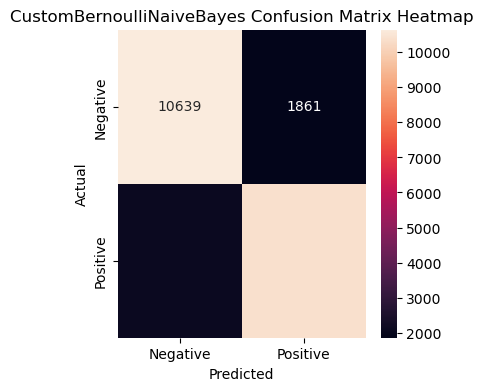

### CustomBernoulliNaiveBayes Metric Table

,Accuracy (Train),Accuracy (Test),Precision (Train),Precision (Test),Recall (Train),Recall (Test),F1 (Train),F1 (Test)
Train Data Used (%),,,,,,,,
20.0,0.873,0.834,0.883,0.847,0.865,0.814,0.874,0.830
40.0,0.861,0.842,0.862,0.847,0.863,0.834,0.863,0.841
60.0,0.857,0.838,0.859,0.847,0.855,0.826,0.857,0.836
80.0,0.852,0.837,0.856,0.849,0.847,0.821,0.852,0.835
100.0,0.853,0.841,0.852,0.848,0.855,0.831,0.854,0.840


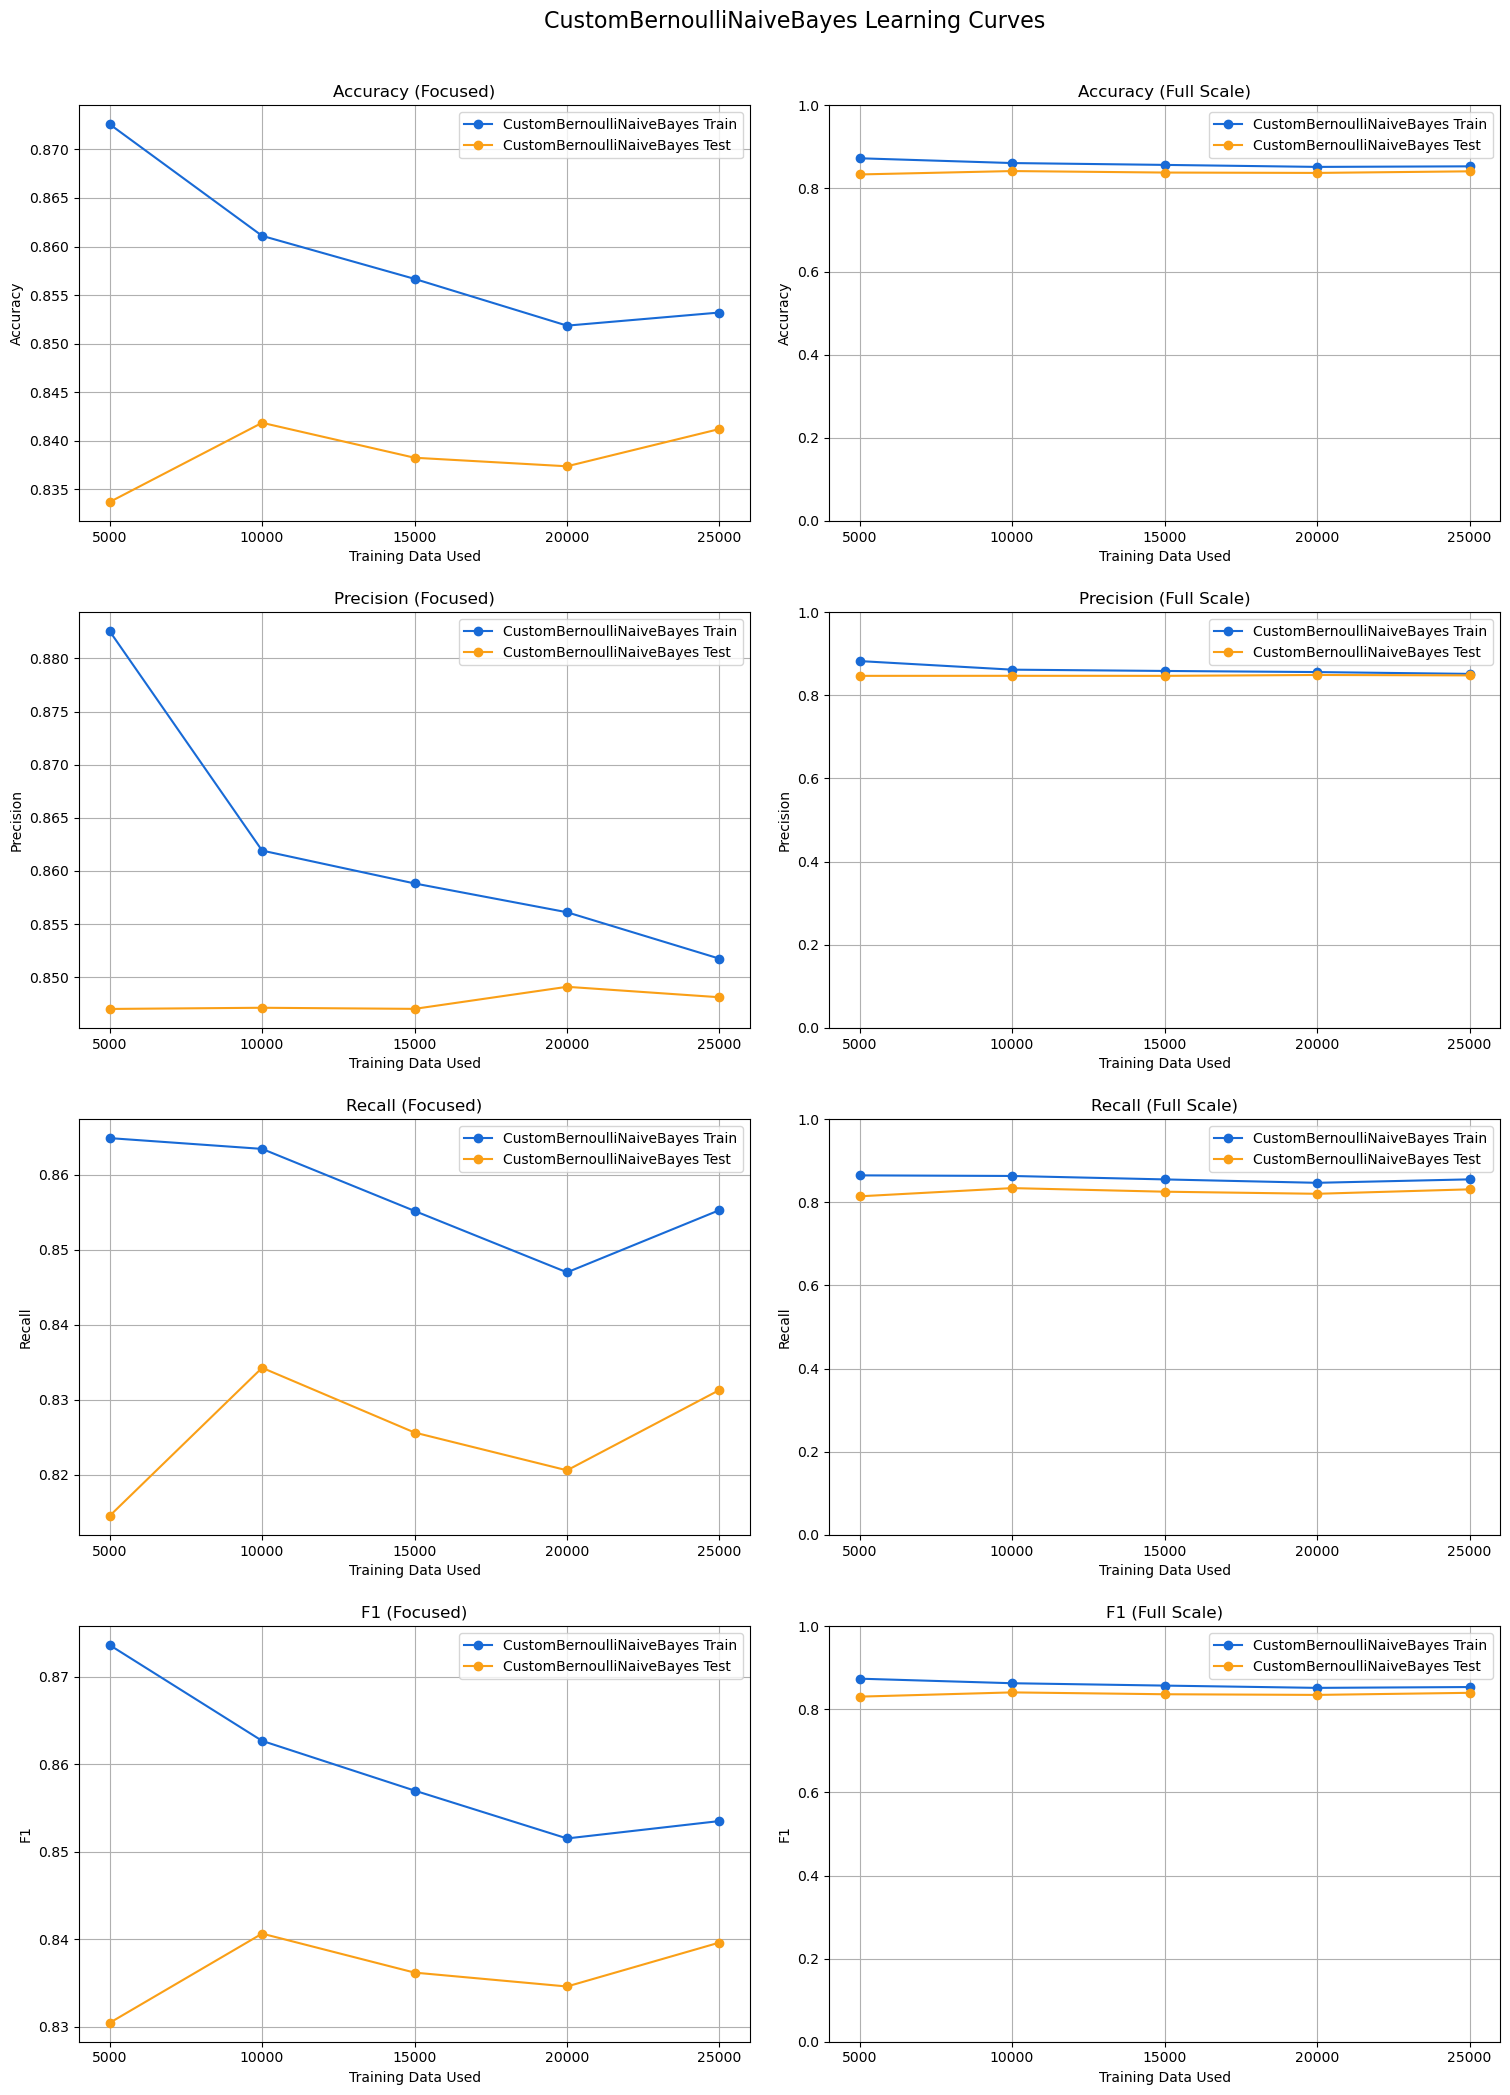

In [9]:
custom_bnb_evaluation = evaluate_model(CustomBernoulliNaiveBayes(), x_train, y_train, x_test, y_test, 5)

## Comparing with Scikit-learn's Bernoulli Naive Bayes
For the second part of the project, our estimator's performance will be evaluated against the performance of Scikit-Learn's equivalent estimator (BernoulliNB).

100%|██████████| 5/5 [00:09<00:00,  1.95s/it]

CustomBernoulliNaiveBayes Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.85      0.84     12500
           1       0.85      0.83      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

BernoulliNB Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.85      0.84     12500
           1       0.85      0.83      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



### CustomBernoulliNaiveBayes Metric Table

,Accuracy (Train),Accuracy (Test),Precision (Train),Precision (Test),Recall (Train),Recall (Test),F1 (Train),F1 (Test)
Train Data Used (%),,,,,,,,
20.0,0.873,0.834,0.883,0.847,0.865,0.814,0.874,0.830
40.0,0.861,0.842,0.862,0.847,0.863,0.834,0.863,0.841
60.0,0.857,0.838,0.859,0.847,0.855,0.826,0.857,0.836
80.0,0.852,0.837,0.856,0.849,0.847,0.821,0.852,0.835
100.0,0.853,0.841,0.852,0.848,0.855,0.831,0.854,0.840


### BernoulliNB Metric Table

,Accuracy (Train),Accuracy (Test),Precision (Train),Precision (Test),Recall (Train),Recall (Test),F1 (Train),F1 (Test)
Train Data Used (%),,,,,,,,
20.0,0.873,0.834,0.883,0.847,0.865,0.814,0.874,0.830
40.0,0.861,0.842,0.862,0.847,0.863,0.834,0.863,0.841
60.0,0.857,0.838,0.859,0.847,0.855,0.826,0.857,0.836
80.0,0.852,0.837,0.856,0.849,0.847,0.821,0.852,0.835
100.0,0.853,0.841,0.852,0.848,0.855,0.831,0.854,0.840


### Metric differences: CustomBernoulliNaiveBayes - BernoulliNB

,Accuracy (Train),Accuracy (Test),Precision (Train),Precision (Test),Recall (Train),Recall (Test),F1 (Train),F1 (Test)
Train Data Used (%),,,,,,,,
20.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
40.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
60.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
80.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
100.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


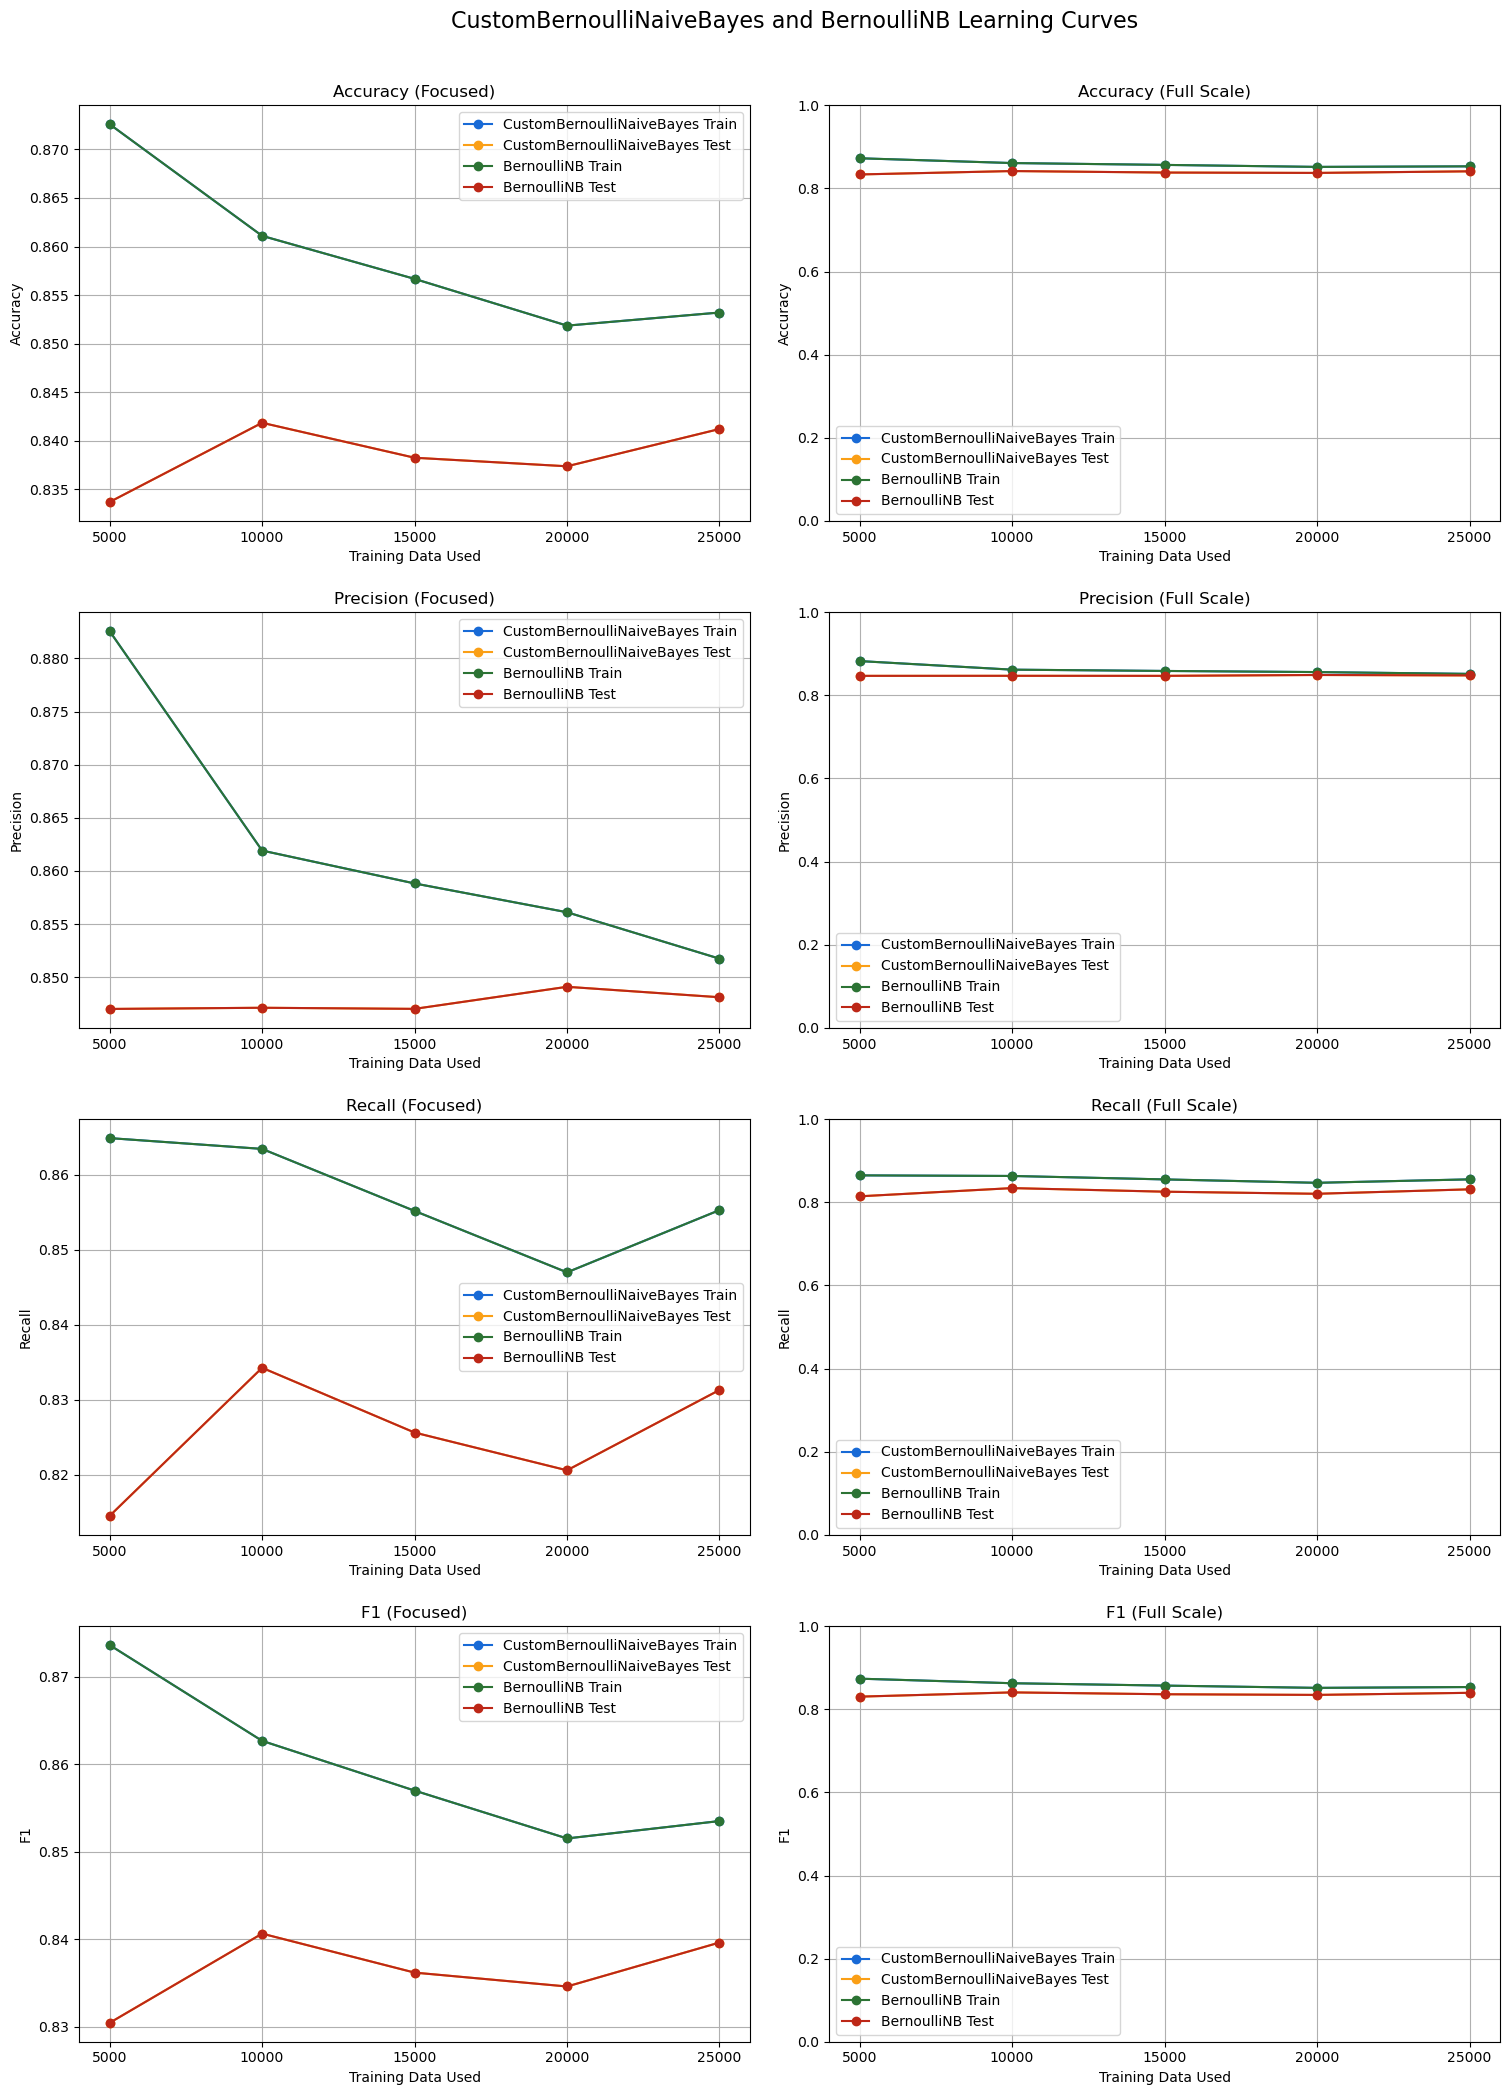

In [10]:
sklearn_bnb_evaluation = evaluate_metrics(BernoulliNB(), x_train, y_train, x_test, y_test, 5)
compare_models(custom_bnb_evaluation, sklearn_bnb_evaluation, y_test)

# RNN
For the third part of the project, a rudimentary bi-directional RNN with GRU cells and a self-attention layer will be implemented in order to demonstrate the difference in performance versus the Naive Bayes estimator developed prior.

## Further Model Evaluation and Visualisation Functions
Similar to the first set of evaluation and visualisation functions earlier, further helper functions were developed. Those include visualisation functions like earlier, along with a function to display the loss curve for the RNN over epochs, and a few trivial helper functions.

In [11]:
def calculate_seq_length(x_train_text, multiplier=1.02):
    """
    Calculates an adaptive sequence length for the train text data, based on the average document length.

    Arguments:
        x_train_text: The train text documents.
        multiplier (optional, default = 1.02): The multiplier by which to adjust the sequence length.
    Returns:
        The product of the mean of the document lengths and the multiplier, rounded up to the nearest integer that is >= to the product.
    """
    document_lengths = np.array([len(str(doc).split()) for doc in x_train_text])
    avg_doc_length = np.mean(document_lengths)
    return int(np.ceil(avg_doc_length * multiplier))

def create_vectorizer(train_vocab, x_train_text, multiplier=1.02):
    """
    Creates a TextVectorization layer with adaptive parameters based on the training data provided.

    More specifically, this function creates a TextVectorization layer with the vocabulary extracted by the training
    data previously, an output mode of 'int' for integer encoding, unigrams (single words), and an output sequence length
    calculated adaptively using the average document length of the training data.

    Parameters:
        train_vocab: Vocabulary derived from the training data.
        x_train_text: The training text documents.
        multiplier (optional, default = 1.02): The multiplier by which to adjust the sequence length.

    Returns:
        A configured TextVectorization layer based on the specified parameters.
    """
    SEQ_MAX_LENGTH = calculate_seq_length(x_train_text, multiplier)
    return tf.keras.layers.TextVectorization(vocabulary=train_vocab,
                                             output_mode='int',
                                             ngrams=1,
                                             name='vector_text',
                                             output_sequence_length=SEQ_MAX_LENGTH)

def display_loss(history, rnn_name):
    """
    Display training and validation loss curves.

    Arguments:
        history (keras.callbacks.History): The history object returned by the model.fit method.
        rnn_name: The name of the RNN model.
    """

    train_loss = history.history['loss']
    train_loss_colour = '#186ad6'
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, color=train_loss_colour, linestyle='-', marker='o', label='Training Loss')

    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        val_loss_colour = '#fa9f16'
        plt.plot(epochs, val_loss, color=val_loss_colour, linestyle='-', marker='o', label='Validation Loss')

    plt.title(f'{rnn_name} Loss Curves')
    plt.xlabel('Epochs')
    plt.xticks(range(1, len(train_loss) + 1))
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluate_metrics_rnn(rnn, x_train, y_train, x_test, y_test, splits=5, epochs=1, batch_size=32, validation_split=0):
    """
    Calculates accuracy, precision, recall, and f1-score for the given splits. Works similarly
    to evaluate_metrics, but with extra available hyperparameters for the rnn training.

    Arguments:
        rnn: The RNN model to be evaluated.
        estimator: The estimator that will be evaluated.
        x_train: The numpy array of binary train data.
        y_train: The corresponding actual positive or negative classifications for x_train.
        x_test: The numpy array of binary test data.
        y_test: The corresponding actual positive or negative classifications for x_test.
        splits (optional, default = 5): The number of splits by which to divide the data.
        epochs (optional, default = 1): The number of epochs used to train the RNN model.
        batch_size (optional, default = 32): The batch size used for training the RNN model.
        validation_split (optional, default = 0): The proportion of the training data to use as validation data during training.

    Returns:
        A dictionary containing evaluation metrics for both train and test datasets.
    """

    # sanity check: Making sure x_train and x_test match the shapes of y_train and y_test respectively
    if x_train.shape[0] != y_train.shape[0]:
        raise ValueError("The number of data points in x_train and y_train must be the same. "
                        f"Found {x_train.shape[0]} data points in x, but {y_train.shape[0]} data points in y.")
    elif x_test.shape[0] != y_test.shape[0]:
        raise ValueError("The number of data points in x_test and y_test must be the same. "
                        f"Found {x_test.shape[0]} data points in x, but {y_test.shape[0]} data points in y.")

    # x_splits/y_splits: Numpy arrays of size equal to splits; each index contains the data of the corresponding split
    x_splits = np.array_split(x_train, splits, axis=0)
    y_splits = np.array_split(y_train, splits, axis=0)
    
    # test_predictions: Will contain the predictions for test data.
    test_predictions = None
    
    # curr_x_split/curr_y_split: Initialised to none, will be updated throughout the loop following.
    curr_x_split = None
    curr_y_split = None

    # split_sizes: Since we opted for np.array_split instead of np.split, keeping track of the exact size of each split.
    split_sizes = np.array([])
    
    # train/test metric scores: Initialising empty arrays, which will keep track of the metrics we are tracking as the training data increases.
    train_accuracy_scores = np.array([])
    test_accuracy_scores = np.array([])
    train_precision_scores = np.array([])
    test_precision_scores = np.array([])
    train_recall_scores = np.array([])
    test_recall_scores = np.array([])
    train_f1_scores = np.array([])
    test_f1_scores = np.array([])

    for i in tqdm(range(splits)):
        curr_x_split = x_splits[i] if curr_x_split is None else np.concatenate((curr_x_split, x_splits[i]), axis=0)
        curr_y_split = y_splits[i] if curr_y_split is None else np.concatenate((curr_y_split, y_splits[i]), axis=0)

        # record the actual size of the current split
        split_sizes = np.append(split_sizes, curr_x_split.shape[0])

        # train the estimator on the current train data subset
        rnn.fit(curr_x_split, curr_y_split, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

        # get the predictions for x as has been determined up until this point
        train_predictions = rnn.predict(curr_x_split)
        test_predictions = rnn.predict(x_test)

        """
        For the train data, checking estimator's accuracy against the currently examined train data subset.
        For the test data, checking the estimator's accuracy against the entire test data.
        """
        train_accuracy_scores = np.append(train_accuracy_scores, accuracy_score(curr_y_split, train_predictions))
        test_accuracy_scores = np.append(test_accuracy_scores, accuracy_score(y_test, test_predictions))

        train_precision_scores = np.append(train_precision_scores, precision_score(curr_y_split, train_predictions))
        test_precision_scores = np.append(test_precision_scores, precision_score(y_test, test_predictions))

        train_recall_scores = np.append(train_recall_scores, recall_score(curr_y_split, train_predictions))
        test_recall_scores = np.append(test_recall_scores, recall_score(y_test, test_predictions))

        train_f1_scores = np.append(train_f1_scores, f1_score(curr_y_split, train_predictions))
        test_f1_scores = np.append(test_f1_scores, f1_score(y_test, test_predictions))

    # Creating a dictionary with descriptive keys to be returned.
    results_dict = {
        'Estimator': rnn.__class__.__name__,
        'Predictions': test_predictions,
        'Splits': splits,
        'Split Sizes': split_sizes,
        'Train Accuracy': train_accuracy_scores,
        'Test Accuracy': test_accuracy_scores,
        'Train Precision': train_precision_scores,
        'Test Precision': test_precision_scores,
        'Train Recall': train_recall_scores,
        'Test Recall': test_recall_scores,
        'Train F1': train_f1_scores,
        'Test F1': test_f1_scores       
    }

    return results_dict

## BiGRU RNN
The class that consists of the RNN implementation. Makes use of multiple tensorflow functions and classes in the process.

In [9]:
class BiGRU_RNN:
    def __init__(self, vectorizer, num_layers=1, embed_size=64, hidden_size=64, self_attention=True):
        self.vectorizer = vectorizer
        self.num_layers = num_layers
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.self_attention = self_attention
        self.model = self.create_model()
        
    def create_model(self):
        """
        Create the BiGRU_RNN model.

        Returns:
            A compiled Keras Model instance.
        """

        # create input layer
        inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='txt_input')
        
        # apply a TextVectorization layer
        x = self.vectorizer(inputs)

        # apply an Embedding layer
        x= tf.keras.layers.Embedding(input_dim=len(self.vectorizer.get_vocabulary()),
                                     output_dim=self.embed_size,
                                     name="word_embeddings", 
                                     mask_zero=True)(x)
        
        # apply early dropout
        x = tf.keras.layers.Dropout(rate=0.25)(x)
        
        # apply Bidirectional layers
        for n in range(self.num_layers):

            # special case: self_attention is not used, and we are at the last layer
            if (not self.self_attention) and n == self.num_layers - 1:
                x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=self.hidden_size,
                                                                      name=f'bigru_cell_{n}',
                                                                      dropout=0.2))(x)
            else:
                x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=self.hidden_size,
                                                                      name=f'bigru_cell_{n}',
                                                                      dropout=0.2,
                                                                      return_sequences=True))(x)

        # self_attention will be optional, and therefore used only when the class instance is initialised with self_attention=True
        if self.self_attention:
            z = tf.keras.layers.Dense(1)(x)  # attention scores (pre-softmax): apply a linear layer at each state of the RNN.
            x = tf.keras.layers.Lambda(lambda x: self.apply_attention(x))([x, z])
        
        x = tf.keras.layers.Dropout(rate=0.5)(x)
        outputs = tf.keras.layers.Dense(units=1, activation='sigmoid', name='lr')(x)
        self.model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='bigru_rnn')
        self.model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=[tf.keras.metrics.BinaryAccuracy(),
                                    tf.keras.metrics.Precision(),
                                    tf.keras.metrics.Recall()])
        return self.model
    
    def apply_attention(self, x):
        """
        Applies self-attention to the input tensor.

        Arguments:
            A tuple containing the RNN states and attention scores.

        Returns:
            A tensor representing the attended output.
        """
        rnn_states, scores = x
        a = tf.nn.softmax(tf.squeeze(scores, axis=-1), axis=-1)
        x = tf.multiply(tf.expand_dims(a, axis=-1), rnn_states)
        x = tf.math.reduce_sum(x, axis=1)
        return x
    
    def fit(self, x_train, y_train, epochs=1, batch_size=32, validation_split=0):
        """
        Trains the model on the training data.

        Arguments:
            x_train: The training data; 1D array of review texts.
            y_train: The actual training data classifications.
            epochs (optional, default = 1): Number of training epochs.
            batch_size (optional, default = 32): Batch size for training.
            validation_split (optional, default = 0): Fraction of the training data to use as validation data.
        
        Returns:
            A keras History instance containing training metrics.
        """
        return self.model.fit(x=x_train, y=y_train.astype('float32'), epochs=epochs, batch_size=batch_size, validation_split = validation_split, verbose=1)
    
    def predict(self, x_test, threshold=0.5):
        """
        Makes predictions on the test data.

        Arguments:
            x_test: The test data; 1D array of review texts
            threshold (optional, default = 0.5): Threshold for the binary classification.
        
        Returns:
            A numpy array of binary predictions (0 or 1) for each review.
        """
        prob_predictions = self.model.predict(x_test)

        # applying the threshold to obtain binary predictions based on the probabilities
        binary_predictions = np.where(prob_predictions >= threshold, 1, 0)
        
        return binary_predictions.flatten() # in order to match the shape of CustomBernoulliNaiveBayes' predict
    
    def get_model(self):
        """
        Get the underlying Keras model.

        Returns:
            The Keras Model instance the class encapsulates.
        """
        return self.model

### Loss curves
The loss curves for the RNN model will be depicted over 5 epochs, utilizing an 80/20 split for training and validation data.

Epoch 1/5
625/625 [==============================] - 192s 283ms/step - loss: 0.4518 - binary_accuracy: 0.7691 - precision_1: 0.7701 - recall_1: 0.7691 - val_loss: 0.3917 - val_binary_accuracy: 0.8250 - val_precision_1: 0.7603 - val_recall_1: 0.9429
Epoch 2/5
625/625 [==============================] - 174s 279ms/step - loss: 0.3304 - binary_accuracy: 0.8587 - precision_1: 0.8545 - recall_1: 0.8656 - val_loss: 0.3508 - val_binary_accuracy: 0.8498 - val_precision_1: 0.8103 - val_recall_1: 0.9085
Epoch 3/5
625/625 [==============================] - 180s 288ms/step - loss: 0.3118 - binary_accuracy: 0.8676 - precision_1: 0.8630 - recall_1: 0.8750 - val_loss: 0.3414 - val_binary_accuracy: 0.8536 - val_precision_1: 0.8397 - val_recall_1: 0.8696
Epoch 4/5
625/625 [==============================] - 180s 288ms/step - loss: 0.2990 - binary_accuracy: 0.8765 - precision_1: 0.8724 - recall_1: 0.8830 - val_loss: 0.3957 - val_binary_accuracy: 0.8342 - val_precision_1: 0.7754 - val_recall_1: 0.9352
Epoc

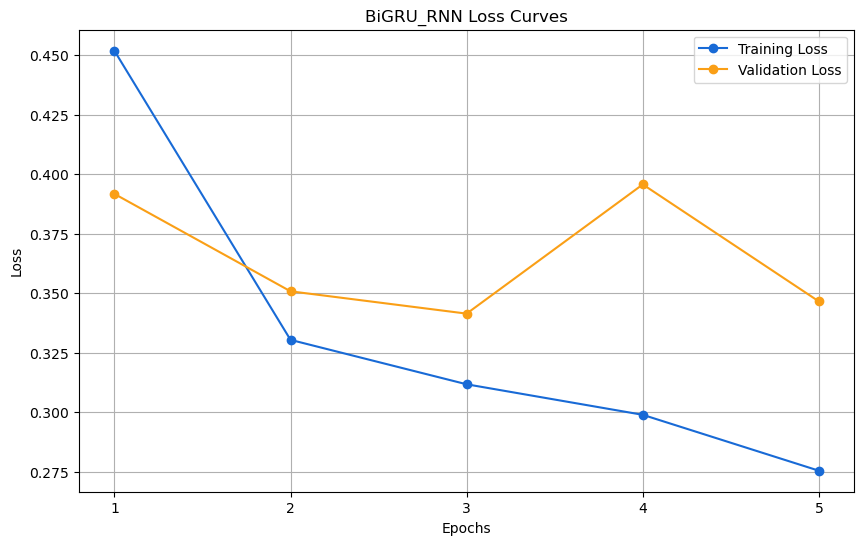

In [12]:
rnn = BiGRU_RNN(vectorizer=create_vectorizer(train_vocab, x_train_text), num_layers=3)
history = rnn.fit(x_train_text, y_train, epochs=5, validation_split=0.2)
display_loss(history, rnn.__class__.__name__)

### (Optional) Plot model
Saves the model to a png file, and displays the picture.

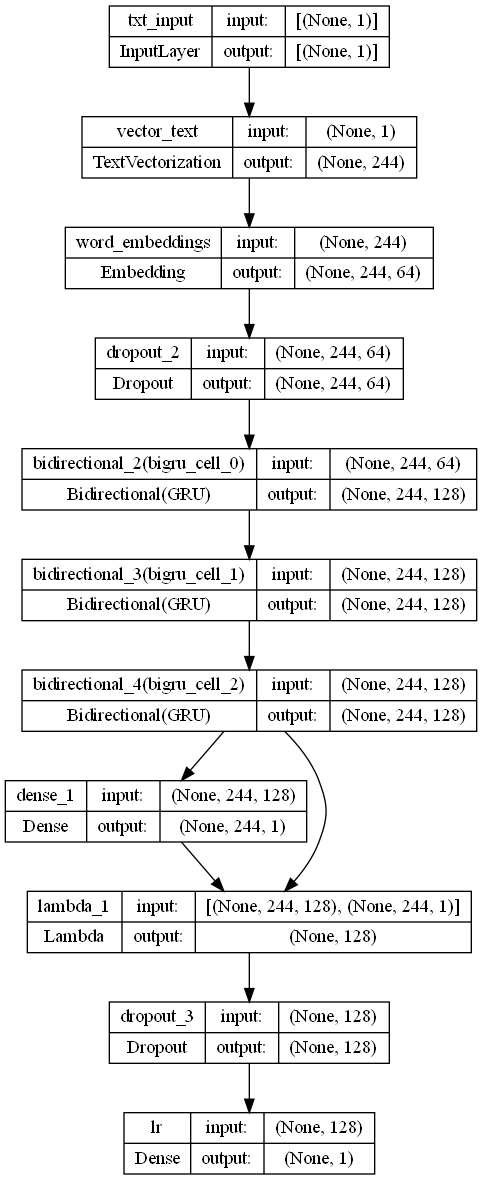

In [13]:
plot_model(rnn.get_model(), to_file='model.png', show_shapes=True)
Image('model.png')

## Comparing with CustomBernoulliNaiveBayes
The RNN model will be evaluated similarly to the two Bernoulli Naive Bayes evaluations earlier, by measuring its performance over a specified number of splits. Afterwards, its performance is compared with the performance of CustomBernoulliNaiveBayes.

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/2
157/157 [==============================] - 20s 89ms/step - loss: 0.6847 - binary_accuracy: 0.5420 - precision_2: 0.5501 - recall_2: 0.5522
Epoch 2/2
782/782 [==============================] - 20s 25ms/step


 20%|██        | 1/5 [01:00<04:02, 60.75s/it]

Epoch 1/2
313/313 [==============================] - 27s 86ms/step - loss: 0.3344 - binary_accuracy: 0.8600 - precision_2: 0.8588 - recall_2: 0.8652
Epoch 2/2
782/782 [==============================] - 19s 25ms/step


 40%|████      | 2/5 [02:23<03:41, 73.86s/it]

Epoch 1/2
469/469 [==============================] - 43s 91ms/step - loss: 0.3066 - binary_accuracy: 0.8726 - precision_2: 0.8704 - recall_2: 0.8769
Epoch 2/2
782/782 [==============================] - 19s 24ms/step


 60%|██████    | 3/5 [04:20<03:07, 93.65s/it]

Epoch 1/2
625/625 [==============================] - 55s 88ms/step - loss: 0.2901 - binary_accuracy: 0.8791 - precision_2: 0.8776 - recall_2: 0.8820
Epoch 2/2
782/782 [==============================] - 21s 26ms/step


 80%|████████  | 4/5 [06:51<01:56, 116.07s/it]

Epoch 1/2
782/782 [==============================] - 73s 93ms/step - loss: 0.2804 - binary_accuracy: 0.8864 - precision_2: 0.8845 - recall_2: 0.8888
Epoch 2/2
782/782 [==============================] - 20s 25ms/step


100%|██████████| 5/5 [09:57<00:00, 119.41s/it]

CustomBernoulliNaiveBayes Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.85      0.84     12500
           1       0.85      0.83      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

BiGRU_RNN Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.85      0.84     12500
           1       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



### CustomBernoulliNaiveBayes Metric Table

,Accuracy (Train),Accuracy (Test),Precision (Train),Precision (Test),Recall (Train),Recall (Test),F1 (Train),F1 (Test)
Train Data Used (%),,,,,,,,
20.0,0.873,0.834,0.883,0.847,0.865,0.814,0.874,0.830
40.0,0.861,0.842,0.862,0.847,0.863,0.834,0.863,0.841
60.0,0.857,0.838,0.859,0.847,0.855,0.826,0.857,0.836
80.0,0.852,0.837,0.856,0.849,0.847,0.821,0.852,0.835
100.0,0.853,0.841,0.852,0.848,0.855,0.831,0.854,0.840


### BiGRU_RNN Metric Table

,Accuracy (Train),Accuracy (Test),Precision (Train),Precision (Test),Recall (Train),Recall (Test),F1 (Train),F1 (Test)
Train Data Used (%),,,,,,,,
20.0,0.905,0.831,0.913,0.842,0.898,0.815,0.906,0.828
40.0,0.916,0.838,0.897,0.819,0.942,0.868,0.919,0.843
60.0,0.911,0.838,0.883,0.812,0.948,0.879,0.914,0.844
80.0,0.897,0.827,0.848,0.780,0.968,0.911,0.904,0.840
100.0,0.922,0.843,0.921,0.845,0.924,0.841,0.923,0.843


### Metric differences: CustomBernoulliNaiveBayes - BiGRU_RNN

,Accuracy (Train),Accuracy (Test),Precision (Train),Precision (Test),Recall (Train),Recall (Test),F1 (Train),F1 (Test)
Train Data Used (%),,,,,,,,
20.0,-0.0320,0.0026,-0.0307,0.0052,-0.0330,-0.0010,-0.0319,0.0020
40.0,-0.0549,0.0040,-0.0349,0.0284,-0.0788,-0.0336,-0.0563,-0.0019
60.0,-0.0541,0.0002,-0.0245,0.0347,-0.0924,-0.0537,-0.0573,-0.0083
80.0,-0.0454,0.0103,0.0078,0.0691,-0.1212,-0.0906,-0.0528,-0.0059
100.0,-0.0692,-0.0020,-0.0694,0.0032,-0.0687,-0.0094,-0.0691,-0.0032


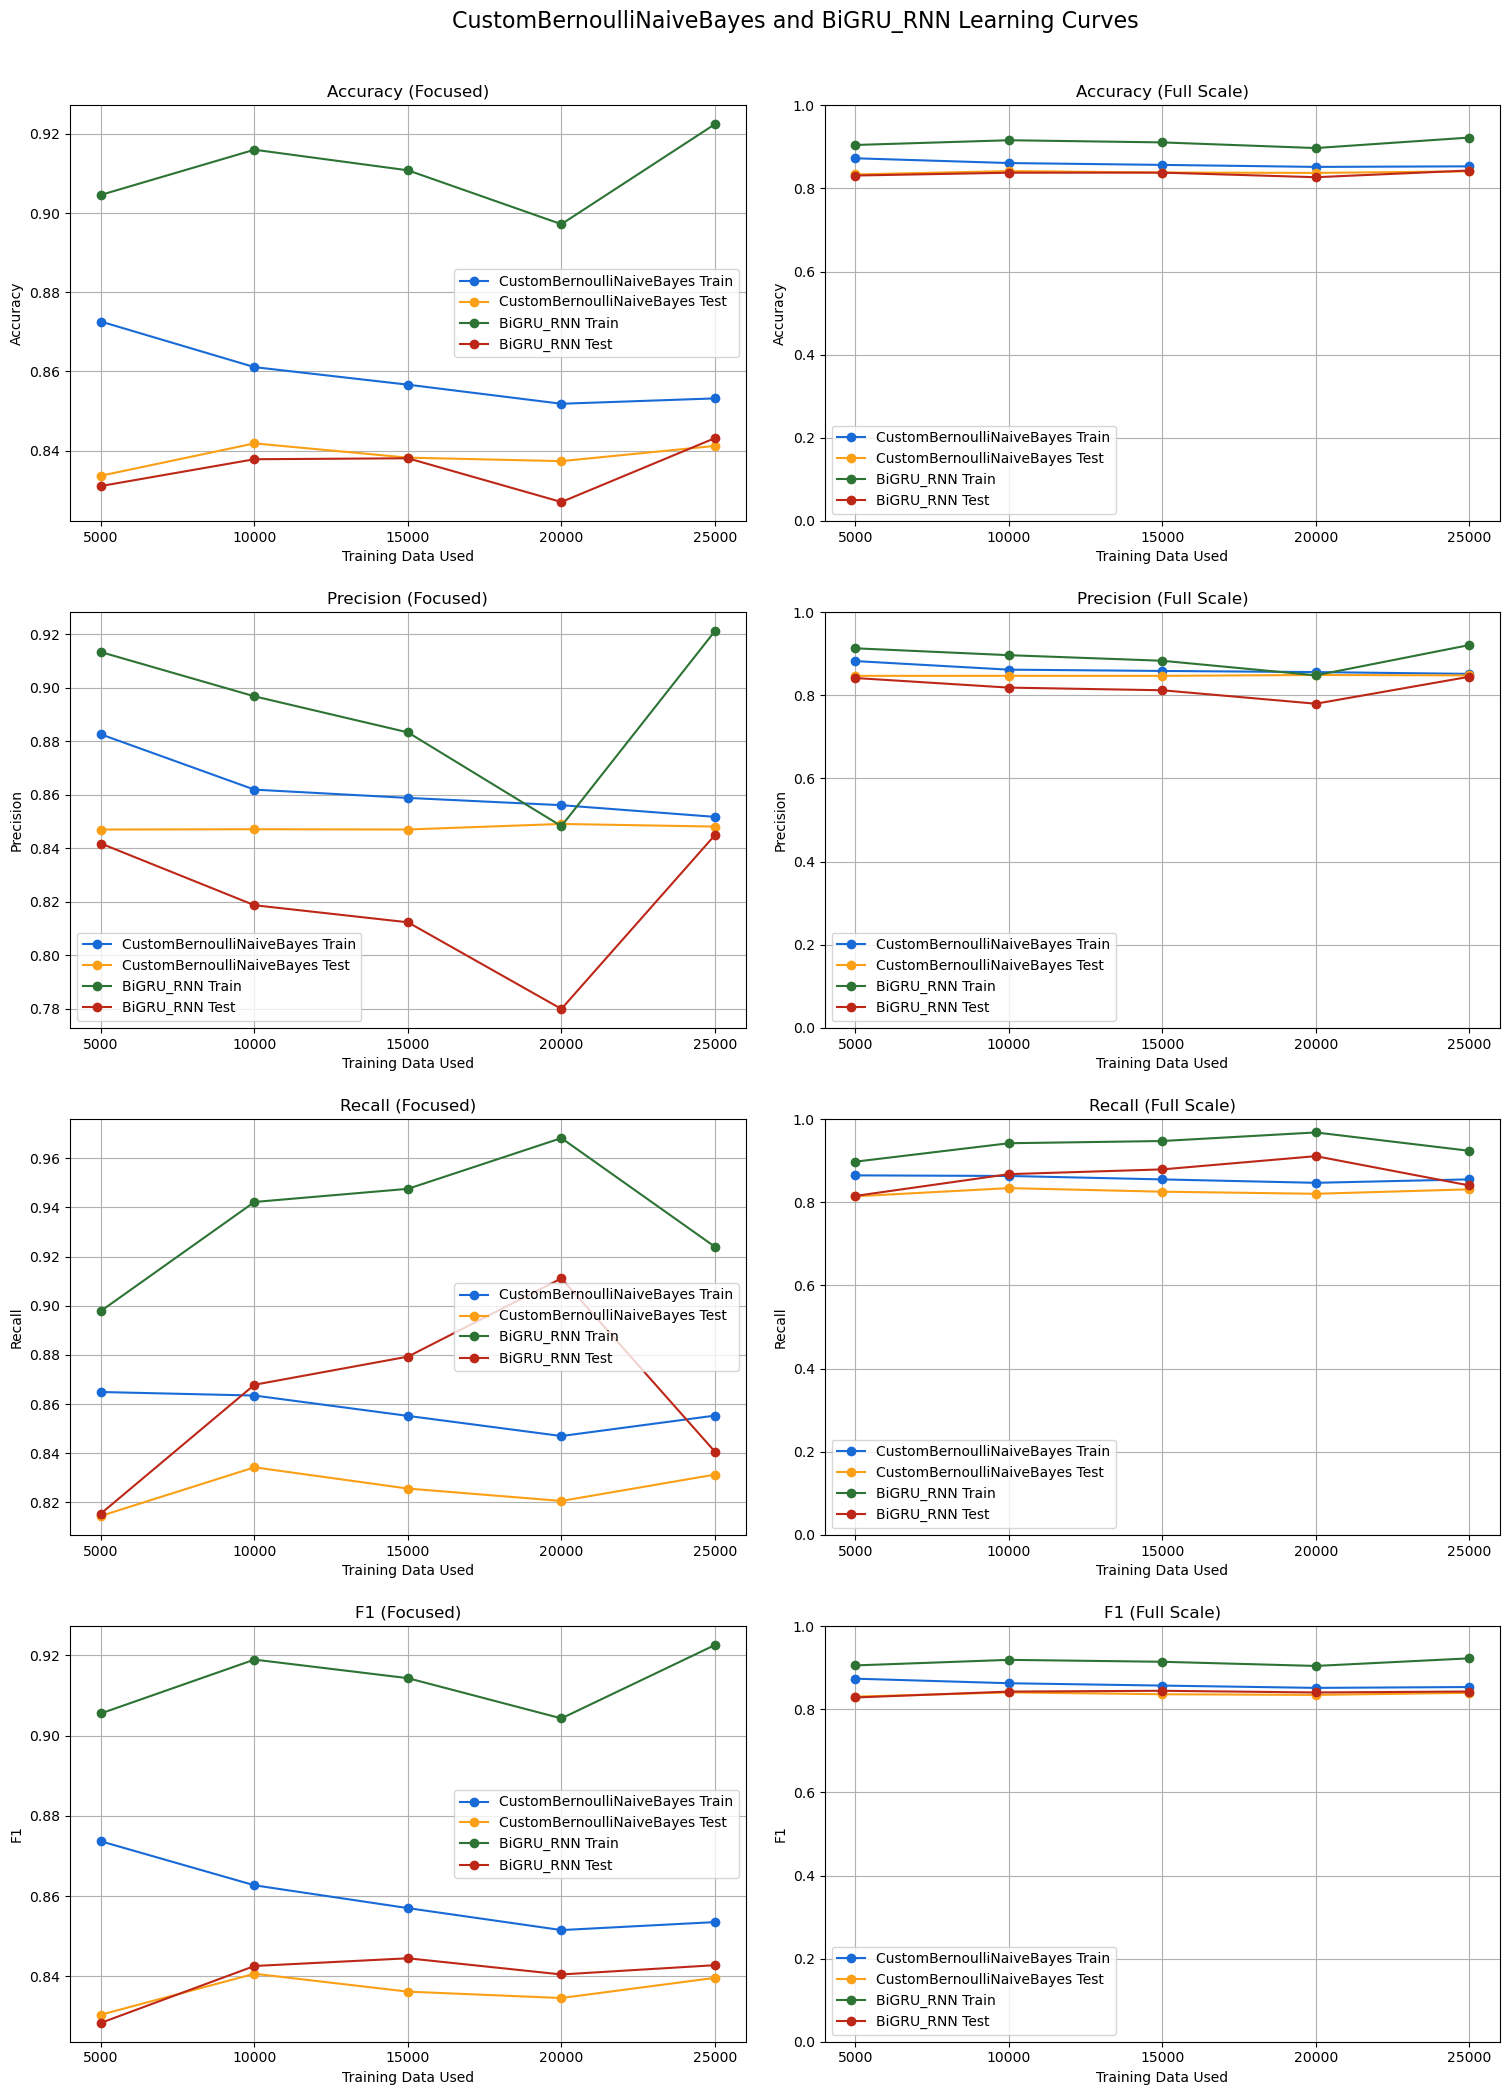

In [14]:
rnn_evaluation = evaluate_metrics_rnn(BiGRU_RNN(vectorizer=create_vectorizer(train_vocab, x_train_text)), x_train_text, y_train, x_test_text, y_test, splits=5, epochs=2)
compare_models(custom_bnb_evaluation, rnn_evaluation, y_test)